In [1]:
# required packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set(style = "whitegrid")
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# load data
raw_recipes = pd.read_csv('data/RAW_recipes.csv')
raw_interaction = pd.read_csv('data/RAW_interactions.csv')

In [3]:
# break up nutrition into different measurements
raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
] = raw_recipes['nutrition'].str.split(",",expand=True) 
raw_recipes['calories'] = raw_recipes['calories'].apply(lambda x: x.replace("[", ""))
raw_recipes['carbohydrates'] = raw_recipes['carbohydrates'].apply(lambda x: x.replace("]", ""))
raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
] =  raw_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
].astype(float)
# raw_recipes.head()

In [4]:
def iqr_bounds(col):
    q1 = np.percentile(raw_recipes[col],25)
    q3 = np.percentile(raw_recipes[col],75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q1 + 1.5*iqr

def drop_query(col, threshold, geq=True):
    """
    Helper to find indcies of observations that contains "unreasonable" values
    ---
    col: column to check
    threshold: threshold
    grq: if the cond will be >= (True), or <= (False)
    ---
    return indcies of observations have value >= or <= the threshold
    """
    if geq:
        return raw_recipes[raw_recipes[col] >= threshold].index.tolist()
    return raw_recipes[raw_recipes[col] <= threshold].index.tolist()

# choice 1 of dropped incies

# to_drop_idx = list(set(
#                 drop_query('calories', 5000) + \
#                 drop_query('total fat', 2000) + \
#                 drop_query('sugar', 1000) + \
#                 drop_query('sodium', 1000) + \
#                 drop_query('protein', 1000) + \
#                 drop_query('saturated fat', 1000) + \
#                 drop_query('carbohydrates', 2000) + \
#                 drop_query('minutes', 2000)
# ))

# choice 2 of dropped incies

to_drop_idx = []
for col in ['calories', 'total fat', 'sugar', 'sodium', 'protein', 
            'saturated fat', 'carbohydrates', 'minutes', 'n_steps', 'n_ingredients']:
    lower, upper = iqr_bounds(col)
    to_drop_idx+=drop_query(col, lower, False) + drop_query(col, upper, True)
to_drop_idx = list(set(to_drop_idx))

In [5]:
# drop observations
cleaned_recipes = raw_recipes.drop(labels=to_drop_idx, axis=0)
print(f'Dropped {raw_recipes.shape[0] - cleaned_recipes.shape[0]} observations')

Dropped 136910 observations


In [6]:
# determine if a recipe is for dessert
all_tags = defaultdict(int)
for obs in cleaned_recipes['tags']:
    for tag in obs[1:-1].replace("'", '').split(", "):
        all_tags[tag] += 1
cleaned_recipes['is_dessert'] = cleaned_recipes['tags'].apply(lambda x: 'desserts' in x)
cleaned_recipes['10_and_more_steps'] = cleaned_recipes['n_steps'].apply(lambda x: x >= 10)
cleaned_recipes['description_len'] = cleaned_recipes['description'].str.len().fillna(0)
# cleaned_recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,calories,total fat,sugar,sodium,protein,saturated fat,carbohydrates,is_dessert,10_and_more_steps,description_len
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,False,True,194.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,173.4,18.0,0.0,17.0,22.0,35.0,1.0,False,False,180.0
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...",...,368.1,17.0,10.0,2.0,14.0,8.0,20.0,False,True,233.0
5,apple a day milk shake,5289,0,1533,1999-12-06,"['15-minutes-or-less', 'time-to-make', 'course...","[160.2, 10.0, 55.0, 3.0, 9.0, 20.0, 7.0]",4,"['combine ingredients in blender', 'cover and ...",NaN,...,160.2,10.0,55.0,3.0,9.0,20.0,7.0,False,False,0.0
6,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,...,380.7,53.0,7.0,24.0,6.0,24.0,6.0,False,False,200.0


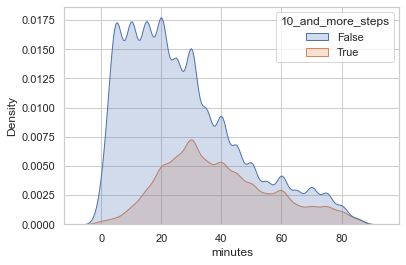

In [7]:
sns.kdeplot(data=cleaned_recipes, x='minutes', fill=True, hue='10_and_more_steps')
plt.show()

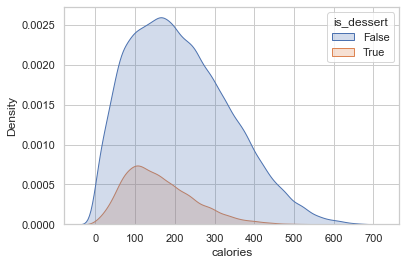

In [8]:
# sns.kdeplot(data=cleaned_recipes[['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']], fill=True)
sns.kdeplot(data=cleaned_recipes, x='calories', fill=True, hue='is_dessert')
plt.show()

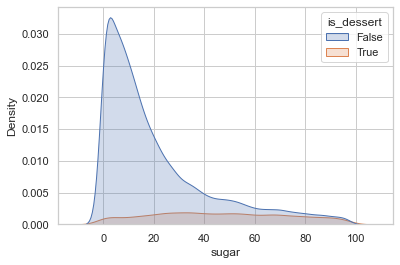

In [9]:
sns.kdeplot(data=cleaned_recipes, x='sugar', fill=True, hue='is_dessert')
plt.show()

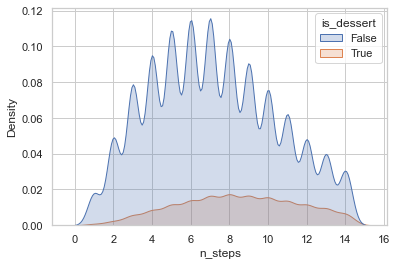

In [10]:
sns.kdeplot(data=cleaned_recipes, x='n_steps', fill=True, hue='is_dessert')
plt.show()

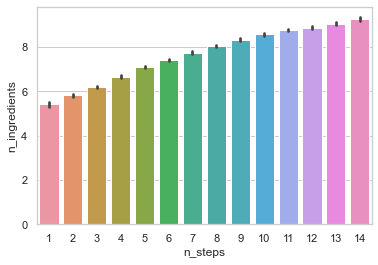

In [11]:
sns.barplot(data=cleaned_recipes, x="n_steps", y="n_ingredients")
plt.show()

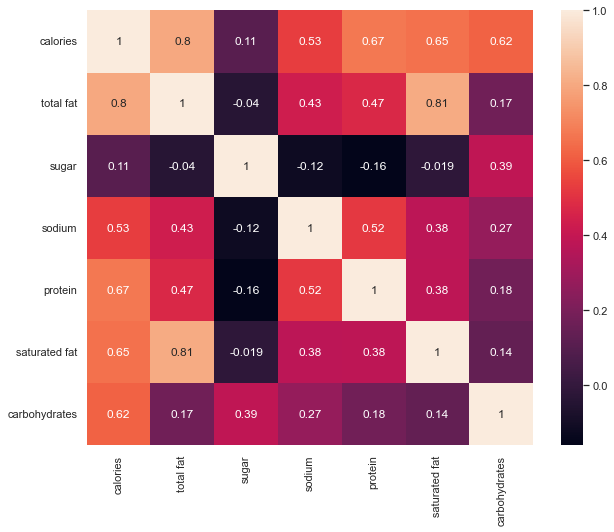

In [12]:
plt.figure(figsize=(10,8))
sns.heatmap(cleaned_recipes[
    ['calories', 'total fat', 'sugar', 'sodium', 'protein', 'saturated fat', 'carbohydrates']
].corr(), annot=True)
plt.show()

In [13]:
data = cleaned_recipes.merge(raw_interaction, left_on='id', right_on='recipe_id')
data.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,saturated fat,carbohydrates,is_dessert,10_and_more_steps,description_len,user_id,recipe_id,date,rating,review
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,0.0,4.0,False,True,194.0,4470,137739,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,0.0,4.0,False,True,194.0,593927,137739,2010-08-21,5,This was a nice change. I used butternut squas...
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,...,0.0,4.0,False,True,194.0,178427,137739,2011-12-05,5,Excellent recipe! I used butternut squash and ...
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,35.0,1.0,False,False,180.0,28603,31490,2002-08-19,0,"Have not tried this, but it sounds delicious. ..."
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,...,35.0,1.0,False,False,180.0,346277,31490,2006-08-27,5,This recipe was wonderful. Instead of using t...


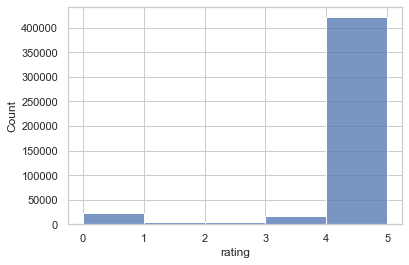

In [14]:
sns.histplot(data=data, x='rating', binwidth=1)
plt.show()

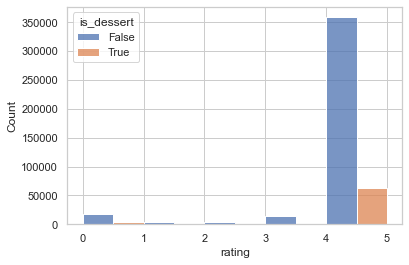

In [15]:
sns.histplot(data=data, hue='is_dessert', x='rating', multiple="dodge", binwidth=1)
plt.show()

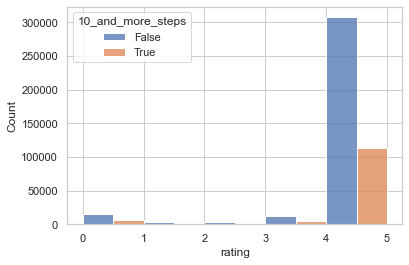

In [16]:
sns.histplot(data=data, hue='10_and_more_steps', x='rating', multiple="dodge", binwidth=1)
plt.show()

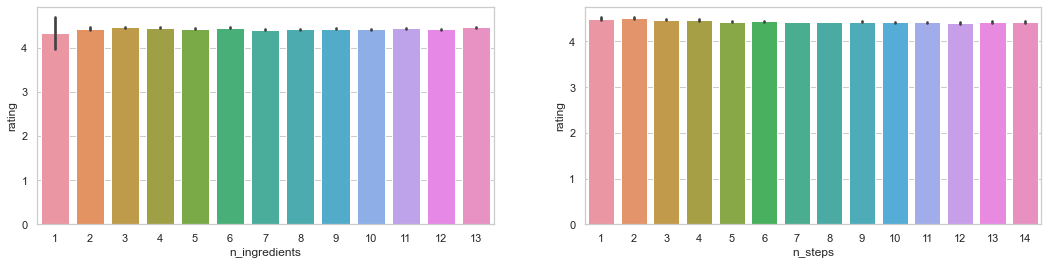

In [17]:
fig,ax = plt.subplots(1,2, figsize=(18,4))
sns.barplot(data=data, x="n_ingredients", y="rating", ax=ax[0])
sns.barplot(data=data, x="n_steps", y="rating", ax=ax[1])
plt.show()

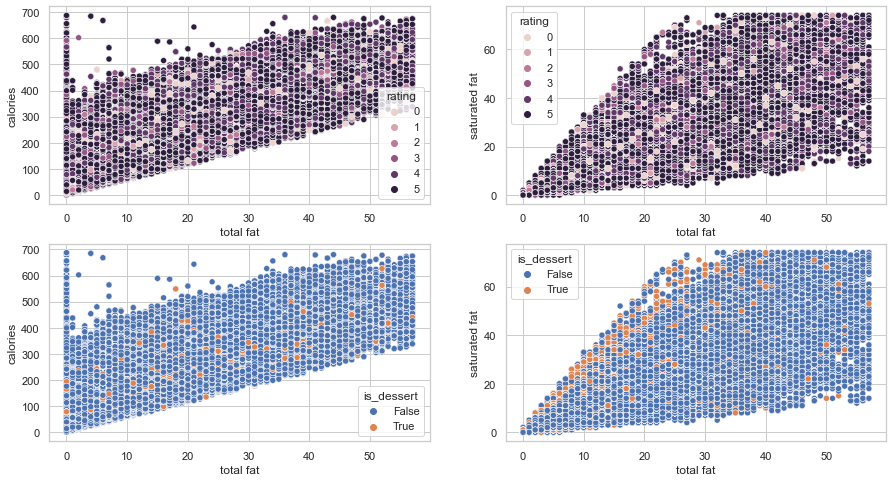

In [18]:
# takes a while to plot because there are lots of points
fig,ax = plt.subplots(2,2,figsize=(15,8))
sns.scatterplot(data=data, x="total fat", y="calories", hue="rating", ax=ax[0, 0])
sns.scatterplot(data=data, x="total fat", y="saturated fat", hue="rating", ax=ax[0, 1])
sns.scatterplot(data=data, x="total fat", y="calories", hue="is_dessert", ax=ax[1, 0])
sns.scatterplot(data=data, x="total fat", y="saturated fat", hue="is_dessert", ax=ax[1, 1])
plt.show()